# Mining Time Series: Matrix Profile

## Background

Matrix profile as the natural evolution of SAX.

The **Matrix Profile**, has the potential to revolutionize time series data mining because of its generality, versatility, simplicity and scalability. In particular it has implications for time series motif discovery, time series joins, shapelet discovery (classification), density estimation, semantic segmentation, visualization, rule discovery, clustering etc.

Assume we have a time series $T$. Note that for most time series data mining tasks, we are not interested in any global properties of the time series, we are only interested in small local subsequences, of this length, $m$. These subsequences might be about the length of individual heartbeats (for ECGs), individual days (for social media behavior), individual words (for speech analysis) etc.

The Matrix Profile is a companion "time series" of the original one such that at the $i$th location it records the distance of the subsequence in $T$, at the $i$th location, to its nearest neighbor. For example, in the below, the subsequence starting at 921 happens to have a distance of 177.0 to its nearest neighbour (wherever it is).

<img src="./images/Matrix_Profile1.png" width="1000" />

Another example. In the below, the subsequence starting at 378 happens to have a distance of 34.2 to its nearest neighbour (wherever it is).

<img src="./images/Matrix_Profile2.png" width="1000" />

There is another companion sequence, called a **matrix profile index**. This allows us to find the nearest neighbor to any subsequence in constant time.

You may have realized that computing the matrix profile is very expensive! If a single Euclidian distance calculation takes  0.0001 seconds, then computing the matrix profile for a tiny dataset can take minutes. And computing matrix profile for a 500,000 length time series may require over 100 days if done in a brute-force manner. However, thanks to a the algorithms developed associated with Matrix Profile for computing distance, this task takes just seconds when running in a standard personal computer.

## Matrix Profile properties
1. The pair of lowest values (it must be a tying pair) are the time series motif. Other definitions of motif can be found quickly using the matrix profile.

<img src="./images/Matrix_Profile3.png" width="1000" />

2. The highest values corresponds to the time series discord (an anomaly). To see this, let us consider another dataset. Below is a slightly noisy sine wave. I have added an anomaly by taking the absolute value in the region between 1,000 and 1,200. The matrix profile strongly encodes ("peaks at") the anomaly.  

<img src="./images/Matrix_Profile4.png" width="1000" />


## Computing the Matrix Profile
Computing the Matrix Profile with a brute force algorithm takes $O(n^2m)$.

* We have an algorithm, Scalable Time series Ordered-search Matrix Profile - **STOMP**, that takes $O(n^2)$.
* We can cast Matrix Profile in an **anytime framework** (interruptible algorithm), making it even faster by a factor of about 100.
* Once the Matrix profile is computed, we can maintain it at 20Hz-plus forever (as an implication, this means we have the first **exact online motif discovery algorithm**, the first **exact online discord discovery algorithm**)
* The algorithm is embarrasingly parallelisable. It can trivially **exploit hardware**: such as GPUs, cloud computing etc.

### Distances
* Euclidean distance metric: Given two time series $x = x_1, \ldots, x_n$ and $y = y_1, \ldots, y_n$ their z-normalised Eclidean distance is defined as:

$$ d(x,y) = \sqrt{\sum_{i=1}^n\left( \hat{x}_i - \hat{y}_i \right)^2} $$

where $\hat{x}_i = \frac{x_i - \mu_x}{\sigma_x}$ and $\hat{y}_i = \frac{y_i - \mu_y}{\sigma_y}$

* The Pearson's correlation coefficient is:

$$ corr(x,y) = \frac{(E(x) - \mu_x)(E(y) -\mu_y)}{\sigma_x\sigma_y} = \frac{\sum_{i=1}^m x_iy_i - m\mu_x\mu_y}{m\sigma_x\sigma_y} $$

Given the sufficient statistics (that can be calculated in one linear scan): $\sum_{i=1}^mx_iy_i$, $\sum_{i=1}^mx_i$, $\sum_{i=1}^my_i$, $\sum_{i=1}^mx_i^2$, $\sum_{i=1}^my_i^2$, the correlation coefficient is a constant operation.

* In relationship with the Euclidean distance we have that $d(\hat{x},\hat{y}) = \sqrt{2m(1-corr(x,y))}$. However, we should count on differences such as:
    * Correlation coefficient does not obey triangular inequality, while Euclidean distance does
    * Maximizing correlation coefficient can be achieved by minimizing normalized Euclidean distance and vice versa
    * Correlation coefficient is bounded between -1 and 1, while z-normalized Euclidean distance is bounded between zero and a positive number dependent on $m$.

Then, the working formula is:

$$ d(\hat{x},\hat{y}) = \sqrt{2m \left(1 - \frac{\sum_{i=1}^mx_iy_i - m\mu_x\mu_y}{m\sigma_x\sigma_y} \right)} $$

Essentially all datasets must have every subsequence z-normalised (even for data don't need it, z-normalising make the process to gain in accuracy and performance).

### Scalable Time series Ordered-search Matrix Profile: STOMP
We can exploit the overlap between successive queries while computing their distance profiles to build an $O(n^2)$ time, $O(n)$ space algorithm.

<img src="./images/Matrix_Profile5.png" width="500" />

All averages and standard deviations are precomputed. This costs linear time and space. The first column and row of the matrix are identical and pre-computed. We iterate through the rows. The previous row is maintained as a local array to feed dot products. The dot products are converted to distance values and compared against the current best in the profile.

<img src="./images/Matrix_Profile6.png" width="500" />

STOMP iterates through rows. Each row depends on the previous row. Therefore random ordering is not suitable. However, the diagonals are independent of each other. We exploit this property to randomize the computation so we achieve an anytime  algorithm. We avoid computing the upper triangle of the matrix because the distance matrix is symmetric.

In [1]:
from matrixprofile import matrixProfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%run -i settings.py

In [2]:
# Load the data
df = pd.read_csv('data/london-2018.csv', 
                 index_col=0, parse_dates=True)
df

drybulb  relhum  glohorrad  rainfall  windspd  winddir
2018-01-01 01:00:00     6.28   90.50        0.0  0.122079    10.25   266.82
2018-01-01 02:00:00     5.79   88.63        0.0  0.013495    10.55   271.34
2018-01-01 03:00:00     5.10   89.76        0.0  0.000444     8.96   260.11
2018-01-01 04:00:00     4.79   91.80        0.0  0.000199     8.02   242.19
2018-01-01 05:00:00     4.84   92.40        0.0  0.000625     7.74   228.02
...                      ...     ...        ...       ...      ...      ...
2018-12-31 20:00:00     7.26   91.93        0.0  0.015533     3.80   276.39
2018-12-31 21:00:00     7.17   92.34        0.0  0.011580     3.78   277.80
2018-12-31 22:00:00     7.06   92.71        0.0  0.009077     3.85   278.38
2018-12-31 23:00:00     6.71   93.86        0.0  0.012057     3.84   279.12
2019-01-01 00:00:00     6.71   93.03        0.0  0.019290     4.32   282.21

[8760 rows x 6 columns]

## Scale data

In [3]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance as TSS

s_raw  = df['drybulb']
s_ref = TSS(mu=0, std=1).fit_transform(s_raw)
s_ref = pd.Series(s_ref[0].ravel(), s_raw.index)
s_ref

2018-01-01 01:00:00   -0.681879
2018-01-01 02:00:00   -0.753458
2018-01-01 03:00:00   -0.854253
2018-01-01 04:00:00   -0.899537
2018-01-01 05:00:00   -0.892233
                         ...   
2018-12-31 20:00:00   -0.538721
2018-12-31 21:00:00   -0.551869
2018-12-31 22:00:00   -0.567937
2018-12-31 23:00:00   -0.619065
2019-01-01 00:00:00   -0.619065
Length: 8760, dtype: float64

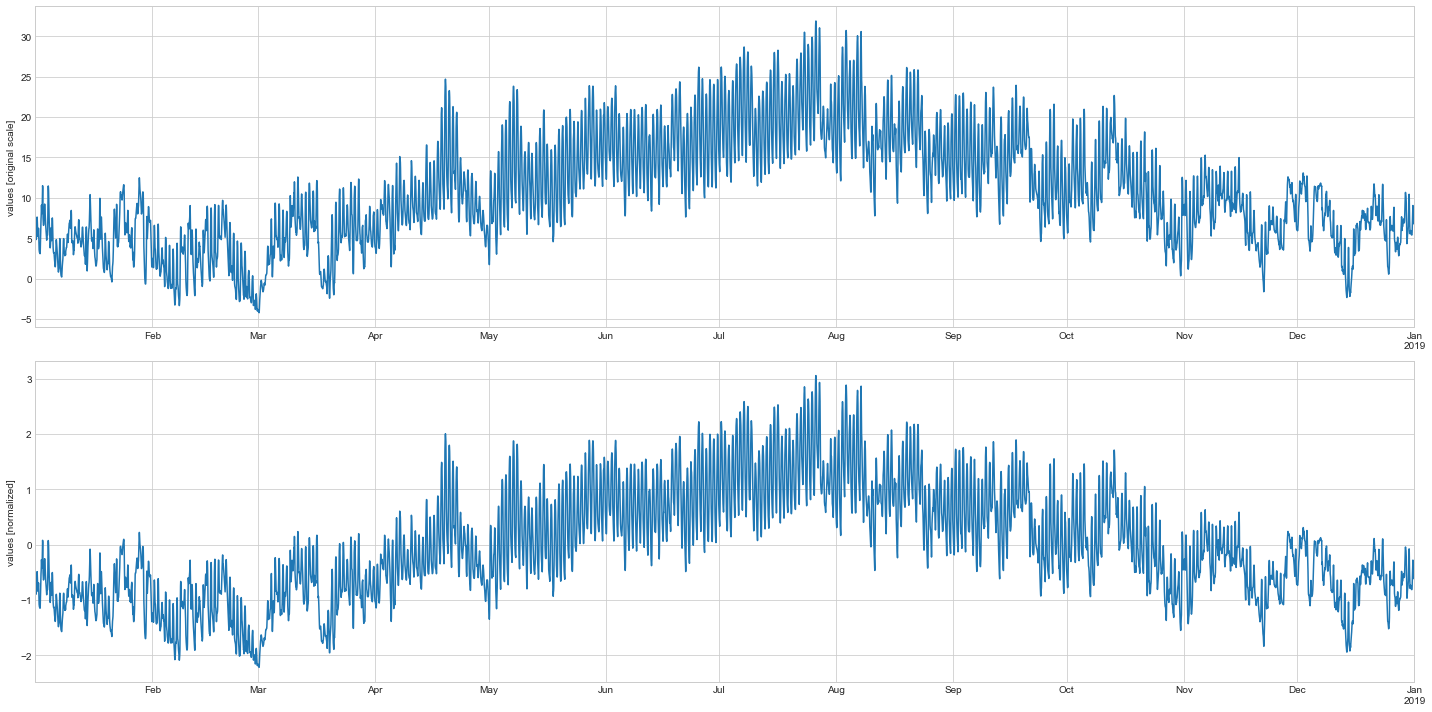

In [4]:
fig, (ax0, ax1) = plt.subplots(figsize=(20, 10), nrows=2)

s_raw.plot(ax=ax0)
ax0.set_ylabel('values [original scale]')

s_ref.plot(ax=ax1)
ax1.set_ylabel('values [normalized]')

plt.tight_layout()
plt.show()

## Matrix Profile

In [5]:
# Define window of interest
# Example: to find similar periods of 24 hours and hourly data
m = 24

# Run
profile = matrixProfile.stomp(s_ref.values, m)

In [6]:
# Export as time series (filling with `nan` at the end for `m`)
df_mp = pd.DataFrame({'value':       s_raw,
                      'profile':     np.append(profile[0], np.full(m - 1, np.nan)),
                      'profile_idx': np.append(profile[1], np.full(m - 1, np.nan)),}, 
                     index=s_raw.index)
df_mp

value   profile  profile_idx
2018-01-01 01:00:00   6.28  2.230733       1512.0
2018-01-01 02:00:00   5.79  2.183548       7562.0
2018-01-01 03:00:00   5.10  2.219145       7563.0
2018-01-01 04:00:00   4.79  2.177365       1996.0
2018-01-01 05:00:00   4.84  2.014335       1997.0
...                    ...       ...          ...
2018-12-31 20:00:00   7.26       NaN          NaN
2018-12-31 21:00:00   7.17       NaN          NaN
2018-12-31 22:00:00   7.06       NaN          NaN
2018-12-31 23:00:00   6.71       NaN          NaN
2019-01-01 00:00:00   6.71       NaN          NaN

[8760 rows x 3 columns]

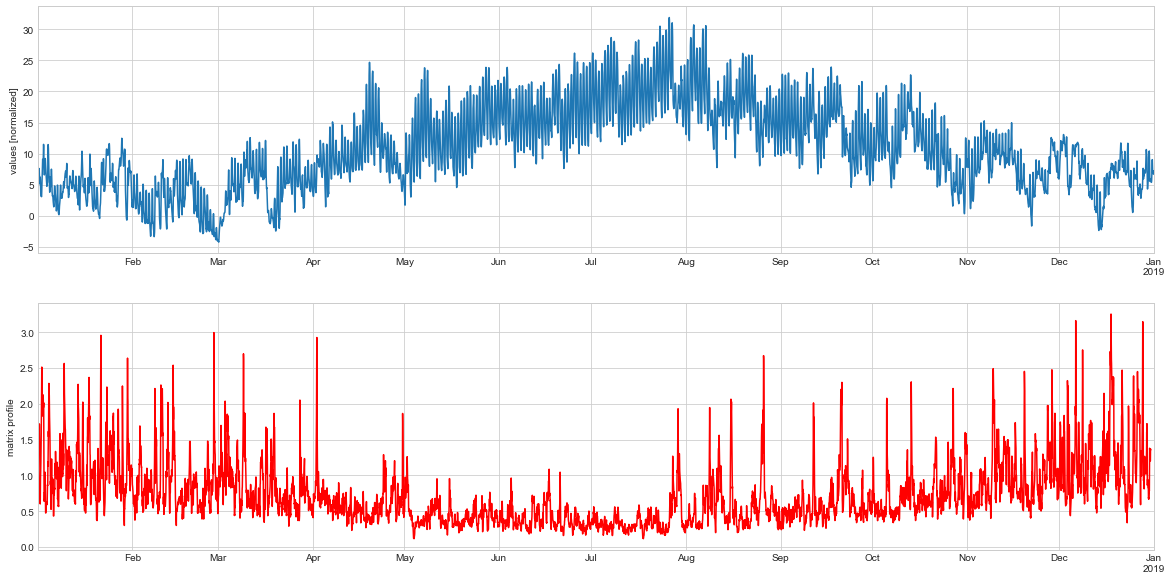

In [7]:
fig, (ax0, ax1) = plt.subplots(figsize=(20, 10), nrows=2)

df_mp['value'].plot(ax=ax0)
ax0.set_ylabel('values [normalized]')

df_mp['profile'].plot(ax=ax1, color='red')
ax1.set_ylabel('matrix profile')

plt.show()

## Detecting anomalies

The points at which the matrix profile are greatests indicate dissimilarity (anomalies).

For example, let's consider the maximum value.

In [8]:
# Find peak value: anomaly starts
anomaly_ini = df_mp['profile'].idxmax()
# - Remember, we used `m` as the window, in hourly data
anomaly_end = anomaly_ini + pd.DateOffset(hours=m)

# Anomaly range
anomaly_ini, anomaly_end

(Timestamp('2018-12-18 02:00:00'), Timestamp('2018-12-19 02:00:00'))

In [9]:
# Comparatively, a different day, say in the same month, 
# with the minimum matrix profile value would be normal
normal_ini = df_mp.loc['2018-12', 'profile'].idxmin()
normal_end = normal_ini + pd.DateOffset(hours=m)
normal_ini, normal_end

(Timestamp('2018-12-23 09:00:00'), Timestamp('2018-12-24 09:00:00'))

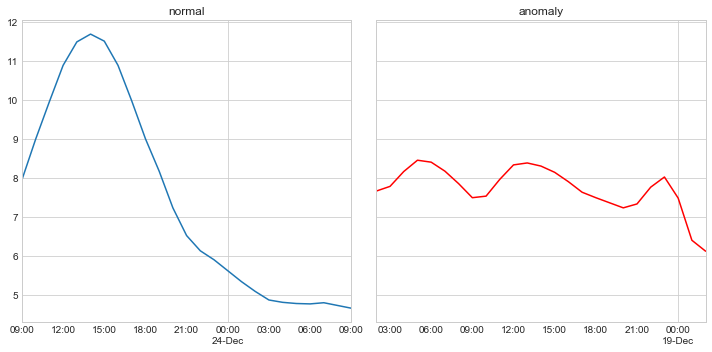

In [10]:
# Dates
dates_anomaly = slice(anomaly_ini, anomaly_end)
dates_normal  = slice(normal_ini,  normal_end)


fig, ax = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
s_raw.loc[dates_normal].plot(ax=ax[0], title='normal')
s_raw.loc[dates_anomaly].plot(ax=ax[1], color='red', title='anomaly')
plt.tight_layout()
plt.show()

In [11]:
# The proper way
from matrixprofile.discords import discords

# Get `k` most significant events
k = 10
idx = discords(df_mp['profile'], ex_zone=m, k=k)
df_mp.iloc[idx]

value   profile  profile_idx
2018-12-18 02:00:00   7.66  3.252346        217.0
2018-12-06 13:00:00  11.38  3.160439        545.0
2018-12-28 11:00:00   6.11  3.146161       1065.0
2018-02-27 17:00:00  -1.40  2.993181       1336.0
2018-01-21 18:00:00   4.31  2.955057       7184.0
2018-04-02 09:00:00   7.88  2.924639       2864.0
2018-12-08 19:00:00   9.98  2.751270       7747.0
2018-03-09 09:00:00   4.79  2.697028       8601.0
2018-08-26 11:00:00  14.78  2.671498       5024.0
2018-01-30 11:00:00   3.20  2.636605       1510.0

## Activities

## Main References

1. Yeh, C. C. M., Zhu, Y., Ulanova, L., Begum, N., Ding, Y., Dau, H. A., ... & Keogh, E. (2016). Matrix profile I: all pairs similarity joins for time series: a unifying view that includes motifs, discords and shapelets. In 2016 IEEE 16th international conference on data mining (ICDM) (pp. 1317-1322). IEEE.
1. Zhu, Y., Zimmerman, Z., Senobari, N. S., Yeh, C. C. M., Funning, G., Mueen, A., ... & Keogh, E. (2016, December). Matrix profile ii: Exploiting a novel algorithm and gpus to break the one hundred million barrier for time series motifs and joins. In 2016 IEEE 16th international conference on data mining (ICDM) (pp. 739-748). IEEE.
1. Dau, H. A., & Keogh, E. (2017, August). Matrix profile V: A generic technique to incorporate domain knowledge into motif discovery. In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 125-134). ACM.
1. Zhu, Y., Yeh, C. C. M., Zimmerman, Z., Kamgar, K., & Keogh, E. (2018, November). Matrix Profile XI: SCRIMP++: Time Series Motif Discovery at Interactive Speeds. In 2018 IEEE International Conference on Data Mining (ICDM) (pp. 837-846). IEEE.